In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

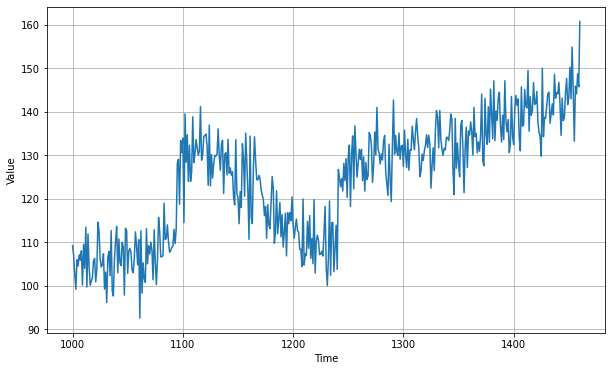

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


In [13]:
# series[0:0 + window_size][np.newaxis]
np.expand_dims(series[0:0 + window_size], 0)

array([[32.48357 , 29.395714, 33.40659 , 37.858486, 29.14184 , 29.20528 ,
        38.32948 , 34.322147, 28.183279, 33.283253, 28.287313, 28.303862,
        31.864614, 21.104889, 22.057411, 27.875519, 25.622026, 32.25094 ,
        26.127428, 23.588236]], dtype=float32)

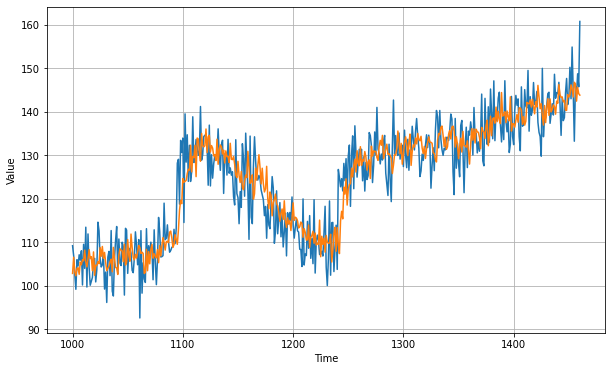

In [6]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7961392

In [36]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history1 = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.0001, 0.0, 300.0)

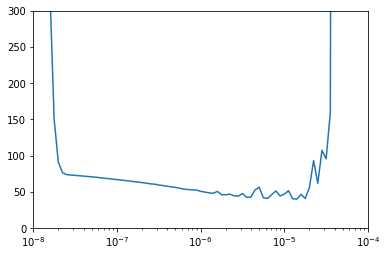

In [44]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history1.history["loss"])
plt.axis([1e-8, 1e-4, 0, 300])

In [45]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=6e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=2)

31/31 - 0s - loss: 35.0314
Epoch 495/500
31/31 - 0s - loss: 33.9942
Epoch 496/500
31/31 - 0s - loss: 33.1962
Epoch 497/500
31/31 - 0s - loss: 36.2102
Epoch 498/500
31/31 - 0s - loss: 35.8642
Epoch 499/500
31/31 - 0s - loss: 32.4973
Epoch 500/500
31/31 - 0s - loss: 33.0208


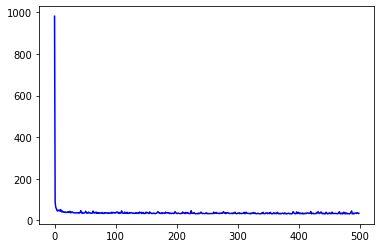

In [46]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[62.635047912597656, 55.77615737915039, 47.14467239379883, 44.809261322021484, 48.749698638916016, 46.29399108886719, 47.86113739013672, 44.4419059753418, 51.617427825927734, 43.37924575805664, 40.02769470214844, 44.28926086425781, 40.510711669921875, 38.64822006225586, 40.31496810913086, 38.491268157958984, 39.818695068359375, 38.40727233886719, 38.186431884765625, 37.752281188964844, 41.269317626953125, 38.957584381103516, 38.4443244934082, 43.29759979248047, 37.13745880126953, 36.26447677612305, 39.934940338134766, 40.361812591552734, 38.223045349121094, 36.09218215942383, 35.98535919189453, 35.45830154418945, 35.16447067260742, 36.044246673583984, 35.62394332885742, 35.33622360229492, 36.080780029296875, 34.850467681884766, 36.78673553466797, 34.71498489379883, 38.048622131347656, 46.13669204711914, 36.95246887207031, 34.424190521240234, 37.330810546875, 34.5201416015625, 34.33220291137695, 35.244911193847656, 36.9576530456543, 43.564327239990234, 37.290367126464844, 33.87731552124

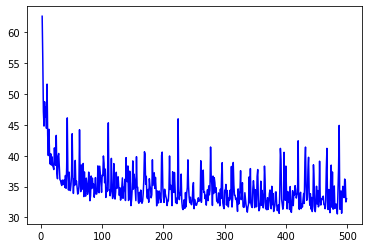

In [49]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(2, len(loss))
plot_loss = loss[2:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

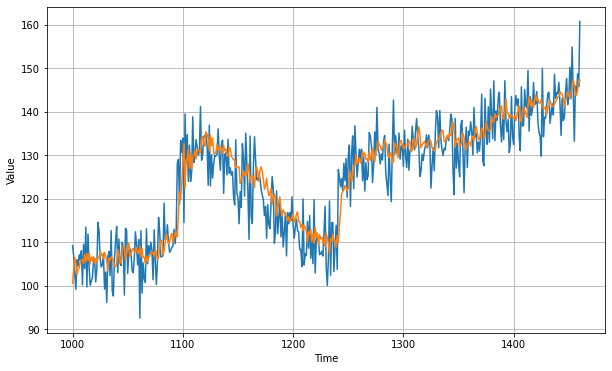

In [50]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [51]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.5987005